In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')
#bbb_df.drop(bbb_df.iloc[:, 3:], inplace=True, axis=1)
bbb_df

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,PROXYPHYLLINE,CC(O)Cn1cnc2c1C(=O)N(C)C(=O)N2C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,THEOBROMINE,Cn1cnc2c1C(=O)NC(=O)N2C,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1655,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1656,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
bbb_df[bbb_df['Drug'] == 'COBALAMINE']

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023


## Getting Fingerprints

In [4]:
r = 2
d = 1024

fp_list = []
for smile in bbb_df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print('invalid SMILES')
        bbb_df = bbb_df[bbb_df['SMILES'] != smile]
    else: 
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,r,nBits=d,useChirality=False)
        fp_list.append(fp)

morgan_list = np.array(fp_list)
print(morgan_list.shape)
print(bbb_df.shape)

(1658, 1024)
(1658, 1027)


## K-Means Clustering

In [5]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(morgan_list)
cluster_index = kmeans.predict(morgan_list)

In [6]:
bbb_df.insert(3, 'Cluster_Index', cluster_index)
bbb_df

,Drug,SMILES,permeable,Cluster_Index,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,2,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,4,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,PROXYPHYLLINE,CC(O)Cn1cnc2c1C(=O)N(C)C(=O)N2C,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,THEOBROMINE,Cn1cnc2c1C(=O)NC(=O)N2C,1.0,2,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1655,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1656,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
count = np.bincount(cluster_index)
index = np.arange(len(count))
number = [i for i in count]
percent = [round(100*i/len(cluster_index), 2) for i in number]
perc_perm = []

for i in index:
    bbb_i = bbb_df[bbb_df['Cluster_Index'] == i]
    num_perm = len(bbb_i[bbb_i['permeable'] == 1])
    perc_perm.append(num_perm/len(bbb_i))

cluster_df = pd.DataFrame(
    {'cluster_index': index,
    'number': number,
    'percentage': percent,
    'percent permeable': perc_perm
    }, index = None)

cluster_df

,cluster_index,number,percentage,percent permeable
0,0,462,27.86,0.965368
1,1,135,8.14,0.000000
2,2,628,37.88,0.909236
3,3,158,9.53,0.981013
4,4,275,16.59,0.527273


## Principal Component Analysis

In [8]:
dim = 100
pca = PCA(n_components=dim)
components = pca.fit_transform(morgan_list)

In [9]:
print("Overall Variance Captured by PCA-1 and PCA-2: ", sum(pca.explained_variance_ratio_[0:2]))
print("50 Principal Components Total Explained Variance: ", sum(pca.explained_variance_ratio_))
print("Fraction of Overall Variance Captured: ",  sum(pca.explained_variance_ratio_[0:2])/sum(pca.explained_variance_ratio_))

Overall Variance Captured by PCA-1 and PCA-2:  0.09747352587759621
50 Principal Components Total Explained Variance:  0.6511225089539188
Fraction of Overall Variance Captured:  0.14970074684439238


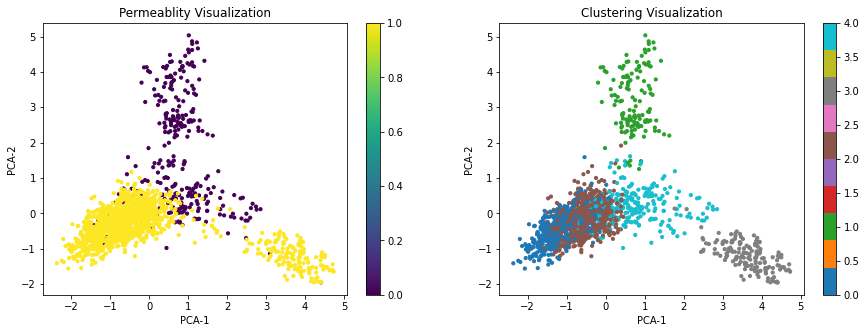

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(components[:,0], components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(components[:,0], components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Clustering Visualization')
plt.colorbar()

## t-SNE

In [11]:
tsne = TSNE(n_components=2, random_state=0)
t_components = tsne.fit_transform(components)

C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


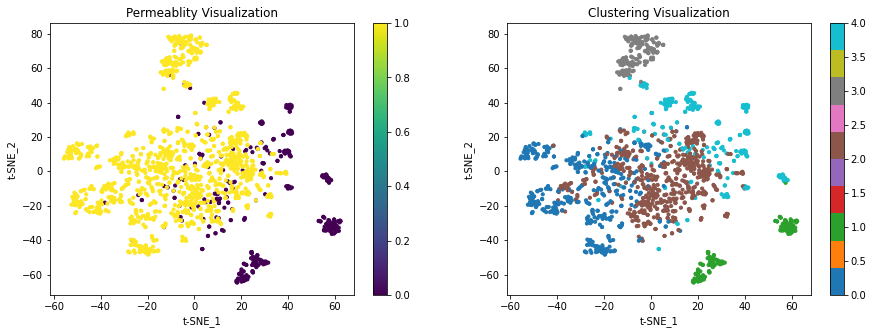

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(t_components[:,0], t_components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(t_components[:,0], t_components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Clustering Visualization')
plt.colorbar()

## Fragment Dictionary

In [13]:
def get_dictionary(smiles_set, feature_list, feature_weights):
    fragment_dict = {key: [val] for key, val in zip(feature_list, feature_weights)}
    r=2
    d=1024
    for smile in smiles_set:
        m = Chem.MolFromSmiles(smile)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(m,r,d,bitInfo=info)
        for bit in info.keys():
            if bit in feature_list:
                root_atom = info[bit][0][0]
                radius = info[bit][0][1]
                env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,root_atom)
                amap={}
                submol=Chem.PathToSubmol(m,env,atomMap=amap)
                if amap:
                    fragment = Chem.MolToSmiles(submol, rootedAtAtom=amap[root_atom],canonical=False)
                else:
                    fragment = Chem.MolToSmiles(submol)
                if bit not in fragment_dict.keys():
                    fragment_dict[bit] = [fragment]
                elif fragment not in fragment_dict[bit]:
                    fragment_dict[bit].append(fragment)
        
    return fragment_dict

### SVM Features by Cluster

In [14]:
## copied from top 20 SVM model feature importances

important_features = [667,
 980,
 700,
 325,
 767,
 580,
 997,
 798,
 264,
 352,
 672,
 119,
 412,
 1010,
 74,
 646,
 138,
 530,
 828,
 78]

feature_weights = [0.13980670764279488,
 0.1411576319439674,
 0.14438885951173616,
 0.14980977631547177,
 0.15188283208396375,
 0.1578963759879286,
 0.15941575138137315,
 0.1603848006150405,
 0.16090741654153815,
 0.16420089036368543,
 0.16544398887507364,
 0.17031250422707883,
 0.17567167003688294,
 0.17977053927709283,
 0.18259849329630726,
 0.18851372644366476,
 0.19020334053489368,
 0.19446214484841093,
 0.20808202632675638,
 0.23581952457052585]

print(len(important_features))

20


In [15]:
svm_fragment_dict = get_dictionary(bbb_df['SMILES'], important_features[-10:], feature_weights[-10:])

In [16]:
svm_fragment_dict_df = pd.DataFrame.from_dict(svm_fragment_dict, orient="index")
svm_fragment_dict_df = svm_fragment_dict_df.rename(columns={0:'Importance'})
svm_fragment_dict_df.sort_values(by='Importance', ascending=False, inplace=True)
svm_fragment_dict_df

,Importance,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
78,0.235820,C(c(c)c)(=O)NC,c(c(C)c)c(c)F,C(NC)(=O)c(c)c,c(c(C)c)(c([nH])c)c(c)C,C(NC)(=O)C(C)(C)C,[C@@](C(C)=C)(C=C)(C)C(C)C,[C@](C(C)C)(C(C)=C)(C=C)C,[C@](C)(C=C)(C(=C)C)C(C)C,[C@](CC)(C)(CC)c(c)c,C(=O)(NC)C(C)(C)C,C(=C(O)c)c(c)c,C(CN)(CO)OC,C(CO)(CN)OC,None,None,None,None
828,0.208082,C(NC)Cc,C(OC)(CC)(OC)CC,S([C@H](C)N)(CC)=O,n(n)(c)-c,C([C@H](c)N)(O)=O,C(N(C)C)(=O)c(c)c,C(Cc)NC,n(c)(n)-c,C(CC)(=C(C)C)C=O,n(n)(C)c,c(n(C)c)(c(c)C)C,C(C)(C)(O)C,None,None,None,None,None
530,0.194462,c(c(n)-c)c(N)c,C(CC)=O,c(c(c)Cl)(cc)Cl,C(C(S)=C)OC,N(c(c)c)C(C)=O,N(C(C)=O)c(c)c,c(c(Cl)c)(cc)Cl,n(C(C)C)(c(=O)c)c(c)c,C([C@H](C)F)(=CC)C(C)(C)C,[C@H](C(C)(C)C)(Cc)N(C)C,n(c(N)c)cc,C(C=C)C(=C)C,c(s)(C)c,None,None,None,None
138,0.190203,C(C)C,[C@@H](C(C)=O)(C)[C@@H](O)C,c(c(C)c)nc,C(NC)(=O)[C@H](N)C,[C@H](C(C)=O)(C)[C@@H](O)C,[C@H]([C@H](C)O)(C)C(=O)C,C(NC)CC,n(N)(c)c,c(c(c)C)nc,C(C=C)(=O)C(=C)Cl,C(CO)[C@@H](O)C,n(nc)(c(n)c)c(c)-c,n(c(-c)c)(c(n)c)nc,None,None,None,None
646,0.188514,c(c)(c)F,c(c(c)O)(c(c)-c)OC,C(N(C)C)c(c)c,C(n(c)c)c(c)c,C(C(C)C)(=O)OC,c(F)(c)c,[N+](=C)([O-])C,N(C(c)(O)c)(CC)CC,[N+]([O-])(=C)C,N(CC)(CC)C(O)(c)c,C(CC)(C)C(C)(C)C,c(CC)(cc)c(c)C,None,None,None,None,None
74,0.182598,C(N(C)C)CN,[nH](c)n,C([C@H](C)N)(=O)OC,[nH](n)c,C(CN)N(C)C,c(c(Br)c)c(c)C,C(C)(C)(c)C,c(c(N)c)cc,N(CC)c(c)c,C(OC)(c(c)c)c(c)c,C(C)(C)(C)c,c(cc)c(c)N,c(cc)c(N)c,[C@]([C@@](O)(C)C)(C(C)(O)C)(C)CC,c(C(C)C)(cc)c(c)Cl,C(c(c)c)(OC)c(c)c,C(C)(C)(C)C
1010,0.179771,c(c)(c)C,c(C)(c)c,c(n(C)c)(=O)n(-c)c,c(c(O)c)c(c)O,c(c)(C)c,c(C(C)c)(cc)cc,O(CC)C(C)(c)c,None,None,None,None,None,None,None,None,None,None
412,0.175672,C(C)(C)(C)C,C(CC)C(N)C,c(c(c)c)(c(c)C)c(n)c,c(c(c)c)(c(n)c)c(C)c,C(O)(Cn)c(c)c,C(C(C)C)=C(C)c,C(N)(C)(C)C,[C@@H](c(c)c)(O)CN,C(c(c)c)(O)CN,O([C@H](O)C)C(C)C,C([C@@H](C)N)CC,n(n)(c)c,n(c)(n)c,C(n(c)c)C(C)=O,None,None,None
119,0.170313,C(CC)(CC)Nc,C(O)(C)C,O(C(C)=O)C(C)(C)C,c(c)(c)[nH],c([nH])(c)c,O(C(C)(C)C)C(C)=O,C(C)(C)O,C(CC)CC,s(c(N)n)c(c)c,S(C)(=O)(=O)N,N(CC)(CC)C(=N)S,C(N(C)c)CN,c(c)([nH])c,c(cc)(cn)Cl,C1(NC)CC1,c(c(N)c)c(c)-c,None
672,0.165444,C([C@](C)(O)C)[C@H](O)C,c(n)(n)c,c(n)(c)[n+],c(n)(c)n,c(n(C)c)(=O)c(c)c,c(c)(n)n,C(C)(F)(F)C,c(n(C)c)(c(c)c)=O,C(C(O)=O)C(C)(C)O,c(c(C)[nH])(c(c)c)CC,c(c(c)C)(c(O)c)C,None,None,None,None,None,None


In [17]:
svm_cluster_df = cluster_df.copy()
for feature in important_features[-10:]:
    feature_perc = []
    feature = str(feature)
    for i in index:
        bbb_i = bbb_df[bbb_df['Cluster_Index'] == i]
        num_on = len(bbb_i[bbb_i[feature] == 1])
        feature_perc.append(num_on/len(bbb_i))
    svm_cluster_df[feature] = feature_perc

In [18]:
svm_cluster_df

,cluster_index,number,percentage,percent permeable,672,119,412,1010,74,646,138,530,828,78
0,0,462,27.86,0.965368,0.015152,0.090909,0.008658,0.030303,0.164502,0.114719,0.134199,0.032468,0.006494,0.002165
1,1,135,8.14,0.000000,0.007407,0.000000,0.014815,0.000000,0.014815,0.000000,0.037037,0.014815,0.014815,0.000000
2,2,628,37.88,0.909236,0.042994,0.052548,0.015924,0.014331,0.073248,0.050955,0.084395,0.015924,0.006369,0.015924
3,3,158,9.53,0.981013,0.000000,0.018987,0.879747,0.000000,0.012658,0.006329,0.443038,0.006329,0.025316,0.126582
4,4,275,16.59,0.527273,0.021818,0.090909,0.029091,0.010909,0.058182,0.065455,0.269091,0.018182,0.018182,0.025455


In [19]:
svm_perm_df = pd.DataFrame()
for feature in important_features[-10:]:
    feature_perm = []
    feature = str(feature)
    for i in range(0,2):
        num_on = len(bbb_df[(bbb_df[feature] == 1) & (bbb_df['permeable'] == i)])
        feature_perm.append(num_on/len(bbb_df[bbb_df['permeable'] == i]))
    svm_perm_df[feature] = feature_perm
    
svm_perm_df.rename(index={0: "Not Permeable", 1: "Permeable"}, inplace=True)

In [20]:
svm_perm_df

,672,119,412,1010,74,646,138,530,828,78
Not Permeable,0.020528,0.038123,0.023460,0.002933,0.023460,0.017595,0.061584,0.020528,0.014663,0.008798
Permeable,0.025816,0.068337,0.117692,0.018983,0.101746,0.074412,0.184510,0.019742,0.009871,0.026576


From this we can gather that 412 and 138 are significant features in predicting that a molecules IS PERMEABLE. Similarly, these features are both highly present in cluster 3.

### XGBoost Features by Cluster

In [21]:
xgb_important_features = ['872',
 '272',
 '399',
 '215',
 '919',
 '829',
 '675',
 '722',
 '808',
 '299',
 '658',
 '606',
 '410',
 '723',
 '430',
 '253',
 '5',
 '357',
 '463',
 '387']
xgb_important_features = [int(val) for val in xgb_important_features]

xgb_feature_weights = [0.015752477571368217,
 0.016555923968553543,
 0.01881934329867363,
 0.01907920651137829,
 0.019553540274500847,
 0.01987210474908352,
 0.01992880366742611,
 0.020168544724583626,
 0.021855978295207024,
 0.022811098024249077,
 0.025636112317442894,
 0.02843727357685566,
 0.029737655073404312,
 0.03191596642136574,
 0.03313911706209183,
 0.03845033794641495,
 0.05527280271053314,
 0.05980795994400978,
 0.0838354155421257,
 0.09129146486520767]

In [22]:
xgb_fragment_dict = get_dictionary(bbb_df['SMILES'], xgb_important_features[-10:], xgb_feature_weights[-10:])

In [23]:
xgb_fragment_dict_df = pd.DataFrame.from_dict(xgb_fragment_dict, orient="index")
xgb_fragment_dict_df = xgb_fragment_dict_df.rename(columns={0:'Importance'})
xgb_fragment_dict_df.sort_values(by='Importance', ascending=False, inplace=True)
xgb_fragment_dict_df

,Importance,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
387,0.091291,N(C)C,[C@@H](C)(O)C,c(c(C)c)(cc)[N+]([O-])=O,c(cn)nc,C(CC)(=O)OC,C(OC)(=O)CC,C(C(=C)C)(O)=O,c(c(c)O)c(c)c,C(=CC)(C)C(=C)C,...,c(C(N)=O)(nc)c(n)C,None,None,None,None,None,None,None,None,None
463,0.083835,C(C)(O)C,c(cc)(cc)F,[C@H](C)(O)C,,c(c(c)O)(c(c)C)C(c)=O,c(c(C)c)(cc)Cl,c(c(C)n)c(c)c,[C@@H](N(C)c)(CC)[C@@H](C)N,C(=CC)C(C)(C)C,...,C(C)(C)(C)C,O(CC)C(=O)O,[C@@H](C)(S)C,n(C)(cn)c(c)c,None,None,None,None,None,None
357,0.059808,c(nc)(cc)c(c)n,C(N=C)#N,c(c(n)c)(cc)nc,O(C)C,C(C)(S)S,C(CC)C=C,s(c(N)n)c(c)c,[C@H](C[S+])(OC)[C@H](C)O,c(c(n)C)(c(n)N)CC,...,None,None,None,None,None,None,None,None,None,None
5,0.055273,C(N)(=O)C,[C@H](NC)(CC)C(=O)N,C(C)(=O)N,[C@@H](C(C)C)(O)CC,C(C)(=C)C,C(S)c,C(NC)(=O)N(C)C,c(C(C)=C)(cc)cc,O(C(C)=O)[C@@H](C)C,...,None,None,None,None,None,None,None,None,None,None
253,0.038450,C(C)(C)C,n(c(c)c)(cc)C(C)C,C(=N/C)\N(C)C,C(=C(S)C)(N(C)C)C(O)=O,[C@@H](OC)([C@@H](C)C)[C@](C)(O)C,C(c(c)c)(=O)C(=C)C,C(C(C)=C)(=O)c(c)c,C(C(=C)C)(=O)c(c)c,C(CN)(N)=O,...,c(cc)(c(c)O)OC,C(CN)NC,n(cc)(C(C)C)c(c)c,c(cc)(c(O)c)OC,[C@@H](CC)(SC)[C@@H](N)C,None,None,None,None,None
430,0.033139,C(CO)(O)CN,C(C)C,C(CN)(O)CO,[C@H](C)(O)[C@H](C)C,[C@H]([C@H](C)C)(C)O,[C@@H](C)(O)[C@H](C)C,c(c(c)O)c(Cl)c,C(CN)Cc,C(Cc)CN,...,None,None,None,None,None,None,None,None,None,None
723,0.031916,c(c)(c)-c,c(c)(C)c,C(c(c)c)([C@H](C)C)c(c)c,c(c(c)c)(c(F)c)C,c(c)(c)C,C(CN)O,N1(C(=C)C)[C@H](S)CC1=O,c(-c)(c)c,c(C)(c)c,...,C(F)(F)O,c(N(C)C)(cn)nc,c(cc)(cc)Cl,c(c)(-c)c,N(C(C)(C)C)(CC)C(C)N,C(C(C)(C)C)C(C)(C)C,None,None,None,None
410,0.029738,[C@H]1(CN)N[C@H]1C,C(C(N)=O)(=CC)C,c([C@H](C)O)(cc)cc,c(C(C)O)(cc)cc,c(c(C)c)(c(c)O)C(=O)C,C(=CC)(C)C(=O)N,O(CC)C(c)C,c(cc)(cc)[C@H](O)C,C(N(C)C)(c(c)c)c(c)c,...,[nH](c(c)C)c(c)C,c(cc)(cc)C(O)C,c(n(-c)c)(nc)C,c(C)(nc)n(c)-c,C(CN)(C)(C)c(c)c,None,None,None,None,None
606,0.028437,C(C)N,c(C(O)=O)(cc)cc,C(N)C,[C@@H](CC)(O)[C@H](C)N,C(C[N+])CC,s(c(N)n)c(c)C,C(Cc)S(O)(=O)=O,C(C)(O)(C)C,c(cc)(c(c)O)NC,...,C(=O)(N(C)C)c(c)n,O(C(C)C)C(N)=O,O(C(C)C)C(=O)N,C([C@@H](C)C)CO,C(=C(C)N)CC,c(C(=O)O)(cc)cc,C(C(C)(C)C)OC,c(c([n+])-c)(cc)c(c)c,C(OC)C(C)(C)C,C(NC)(=S)NC
658,0.025636,C(Oc)C(O)C,c(cc)(c(c)C)-c(c)c,C(C)(C)(C)NC,C(C(C)O)Oc,C(NC)(C)(C)C,c(c(C)n)sc,C(C(O)=O)(CO)c(c)c,C(NC)(=O)C(C)(C)O,N(C(C)=O)CC,...,C(C(C)(O)C)(=O)C(=C)C,[C@@H](C(O)=O)(CO)c(c)c,O(C(=C)C)C(c)(c)N,C(C)(O)O,None,None,None,None,None,None


In [24]:
xgb_cluster_df = cluster_df.copy()

for feature in xgb_important_features[-10:]:
    feature_perc = []
    feature = str(feature)
    for i in index:
        bbb_i = bbb_df[bbb_df['Cluster_Index'] == i]
        num_on = len(bbb_i[bbb_i[feature] == 1])
        feature_perc.append(num_on/len(bbb_i))
    xgb_cluster_df[feature] = feature_perc

In [25]:
xgb_cluster_df

,cluster_index,number,percentage,percent permeable,658,606,410,723,430,253,5,357,463,387
0,0,462,27.86,0.965368,0.008658,0.015152,0.015152,0.021645,0.015152,0.015152,0.030303,0.008658,0.034632,0.021645
1,1,135,8.14,0.000000,0.022222,0.029630,0.000000,0.037037,0.059259,0.029630,0.918519,0.007407,0.081481,0.822222
2,2,628,37.88,0.909236,0.020701,0.039809,0.017516,0.025478,0.017516,0.019108,0.025478,0.011146,0.027070,0.014331
3,3,158,9.53,0.981013,0.018987,0.018987,0.000000,0.006329,0.000000,0.006329,0.000000,0.000000,0.006329,0.018987
4,4,275,16.59,0.527273,0.083636,0.101818,0.047273,0.178182,0.061818,0.094545,0.065455,0.210909,0.280000,0.120000


In [26]:
xgb_perm_df = pd.DataFrame()
for feature in xgb_important_features[-10:]:
    feature_perm = []
    feature = str(feature)
    for i in range(0,2):
        num_on = len(bbb_df[(bbb_df[feature] == 1) & (bbb_df['permeable'] == i)])
        feature_perm.append(num_on/len(bbb_df[bbb_df['permeable'] == i]))
    xgb_perm_df[feature] = feature_perm
    
xgb_perm_df.rename(index={0: "Not Permeable", 1: "Permeable"}, inplace=True)

In [27]:
#Displays the percentage of not permeable/permeable molecules that have that feature bit ON
xgb_perm_df

,658,606,410,723,430,253,5,357,463,387
Not Permeable,0.102639,0.129032,0.049853,0.173021,0.090909,0.099707,0.434018,0.190616,0.243402,0.428152
Permeable,0.008352,0.017464,0.010630,0.016705,0.009112,0.012149,0.018223,0.003797,0.029613,0.015186


From this we can interpret that the model is making predictions of what will be a NON PERMEABLE molecule. This is indicated by the high prevalence of important features that are indicative of a non permeable molecule. Features 387 and 5 are the most abundant.

## Get Fragments By Cluster
### + Scaffold Analysis

In [28]:
from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys
)

In [29]:
def get_fragments(smiles_set, feature_list):
    fragments_df = pd.DataFrame(columns=['Fragment', 'Count'])
    r=2
    d=1024
    for smile in smiles_set:
        m = Chem.MolFromSmiles(smile)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(m,r,d,bitInfo=info)
        fragments = []
        for bit in info.keys():
            if bit in feature_list:
                root_atom = info[bit][0][0]
                radius = info[bit][0][1]
                env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,root_atom)
                amap={}
                submol=Chem.PathToSubmol(m,env,atomMap=amap)
                if amap:
                    fragment = Chem.MolToSmiles(submol, rootedAtAtom=amap[root_atom],canonical=False)
                else:
                    fragment = Chem.MolToSmiles(submol)
                fragments.append(fragment)
        
        for fragment in fragments:
            if fragment in fragments_df['Fragment'].values:
                index = fragments_df.index[fragments_df['Fragment'] == fragment]
                fragments_df.at[index[0],'Count'] = fragments_df.at[index[0],'Count'] + 1
            else:
                row = {'Fragment': [fragment], 'Count': [1]}
                row_df = pd.DataFrame(data=row)
                fragments_df = pd.concat([fragments_df, row_df], ignore_index=True)
    return fragments_df

In [30]:
def cluster_fragments(cluster_df, features):
    fragments = get_fragments(cluster_df['SMILES'], features)
    fragments = fragments.sort_values(by=['Count'], ascending=False)[1:]
    mol = [Chem.MolFromSmiles(s) for s in cluster_df['SMILES'].values[:10]]
    grid = Draw.MolsToGridImage(
        mol, 
        molsPerRow=5, 
        subImgSize=(300, 300), 
        legends=cluster_df['Drug'].values.tolist()[:10]
    )
    return fragments, grid

### Cluster 0

In [31]:
fragments_c0, grid_c0 = cluster_fragments(bbb_df[bbb_df['Cluster_Index'] == 0], important_features)

In [32]:
fragments_c0.head(20)

,Fragment,Count
12,c(C)(c)c,63
13,C(C)C,54
1,c(c)(c)F,47
8,C(N(C)C)CN,44
22,C(CN)N(C)C,43
33,c(c)(C)c,33
16,C(N)(=O)C,32
27,c(c)(c)C,25
56,c(F)(c)c,22
39,c([nH])(c)c,22


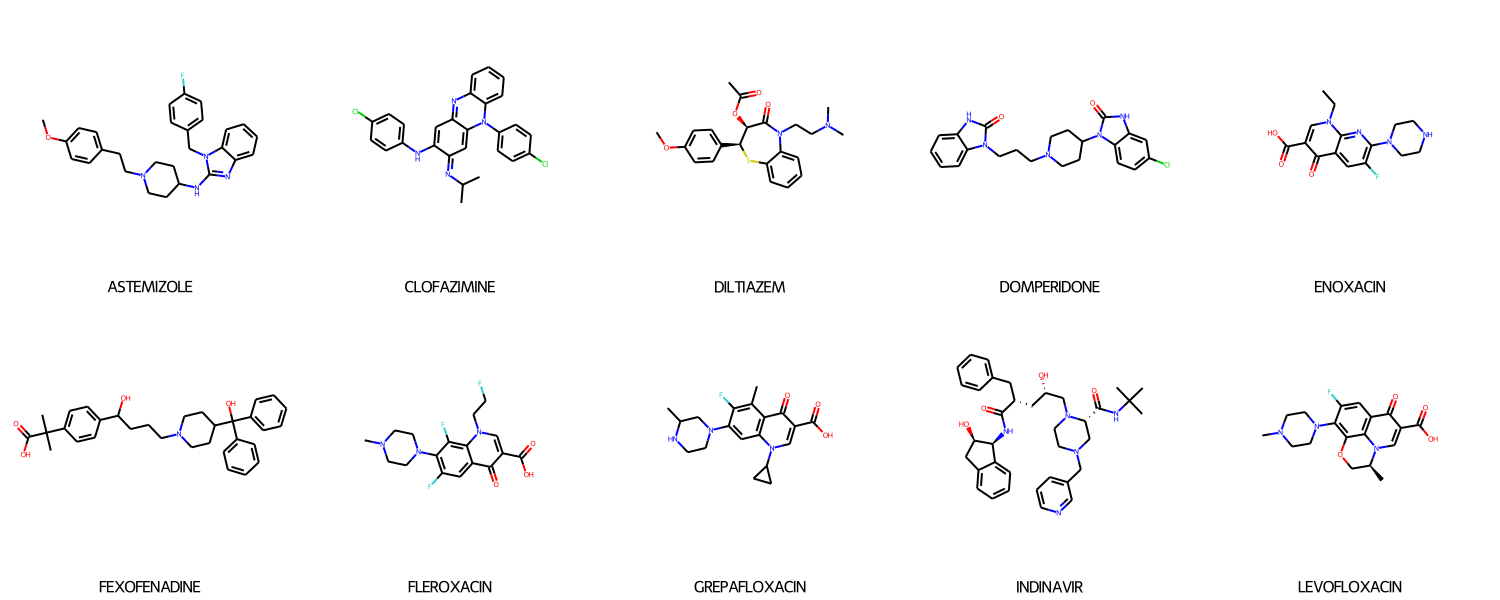

In [33]:
grid_c0

### Cluster 1

In [34]:
fragments_c1, grid_c1 = cluster_fragments(bbb_df[bbb_df['Cluster_Index'] == 1], important_features)

In [35]:
fragments_c1.head(20)

,Fragment,Count
7,C(C)c,11
8,C(O)C,5
0,c(sc)c(n)C,3
13,[C@@H]1(SC)[C@](O)(N)CN1C,3
10,o(c)c,2
22,C(C)C,2
1,C(CC)C(N)C,2
14,C(c)C,2
12,n(c)[nH],2
16,c(-c)(c)c,2


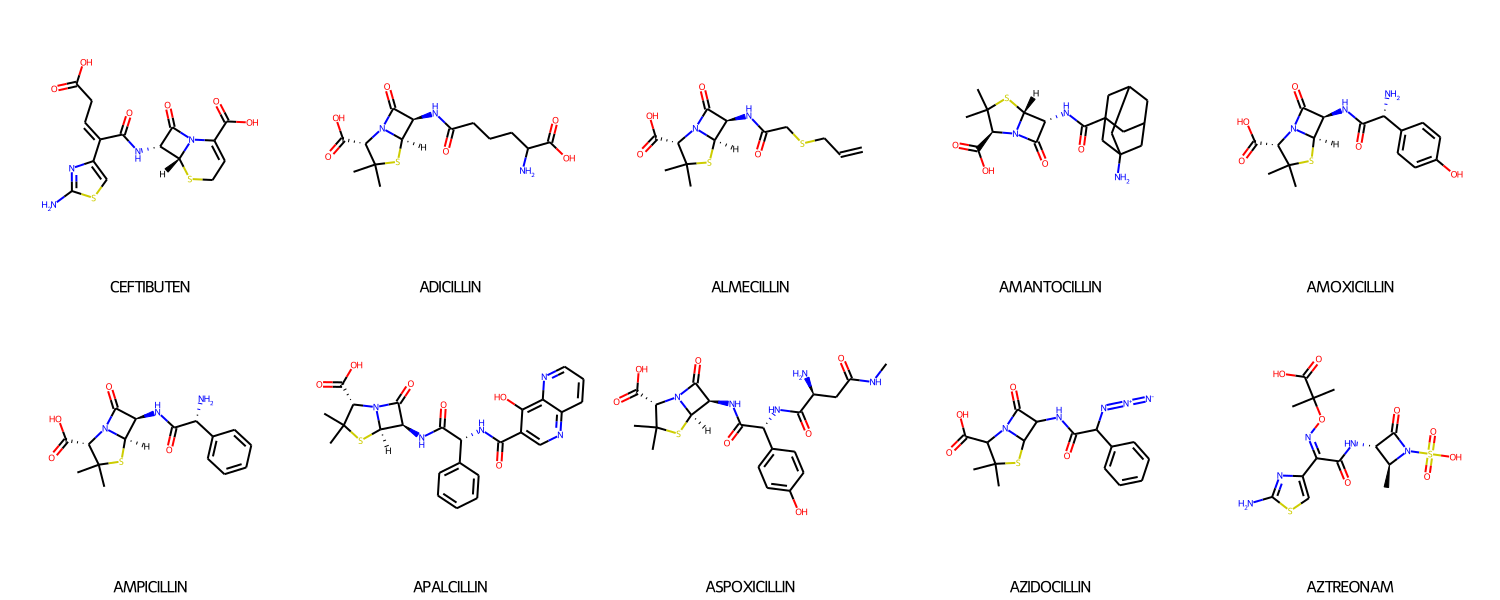

In [36]:
grid_c1

### Cluster 2

In [37]:
fragments_c2, grid_c2 = cluster_fragments(bbb_df[bbb_df['Cluster_Index'] == 2], important_features)

In [38]:
fragments_c2

,Fragment,Count
2,C(N)C,34
21,C(C)C,25
9,C(C)N,23
18,c(c)(c)C,17
12,c(n)(n)c,16
...,...,...
61,c(F)(c)c,1
58,[C@H](O)(C)C,1
57,C(N(C)c)CN,1
56,C(C(C)(C)O)C(C)(O)c,1


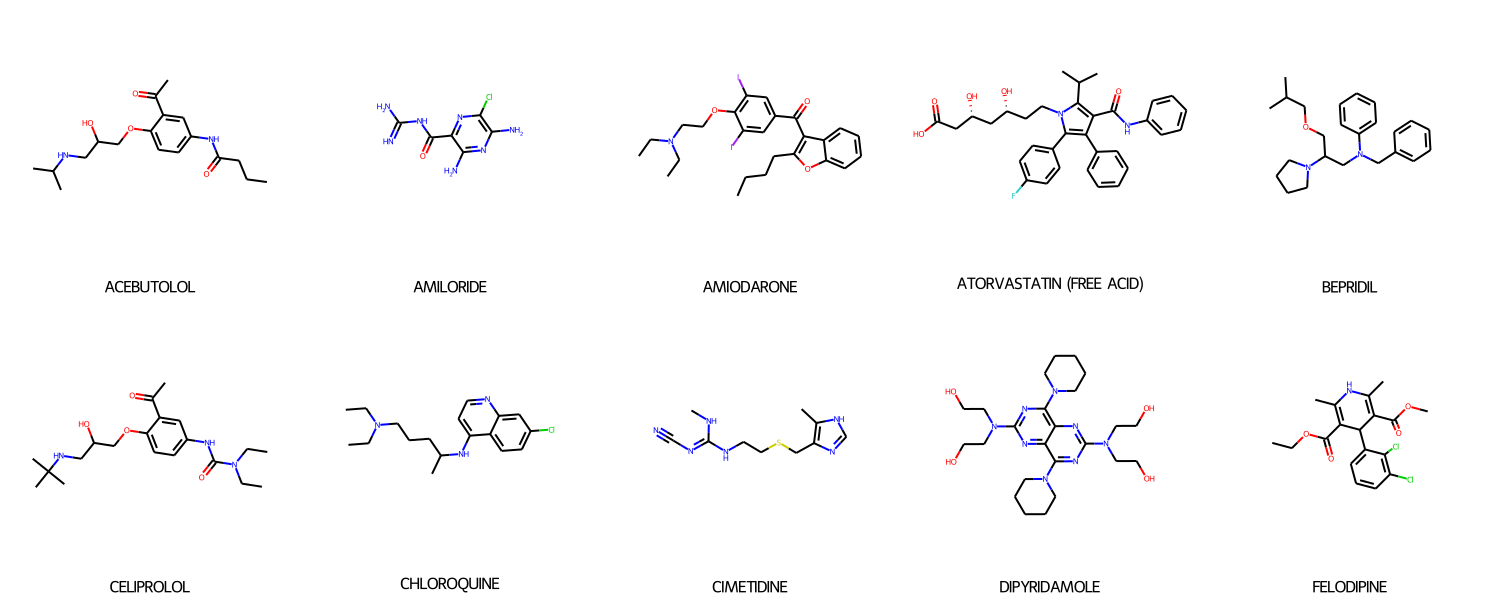

In [39]:
grid_c2

### Cluster 3

In [40]:
fragments_c3, grid_c3 = cluster_fragments(bbb_df[bbb_df['Cluster_Index'] == 3], important_features)

In [41]:
fragments_c3.head(20)

,Fragment,Count
2,C(C(C)=O)=CC,110
0,C(C)C,67
6,C(O)C,31
9,C(C)O,28
3,C(CC)[C@](O)(C)C,22
4,[C@@](C(C)=C)(C=C)(C)C(C)C,17
12,C([C@@](C)(O)C)CC,16
5,O(C(C)=O)CC,13
13,C(=CC)C(=O)C,10
11,C(C)Cl,9


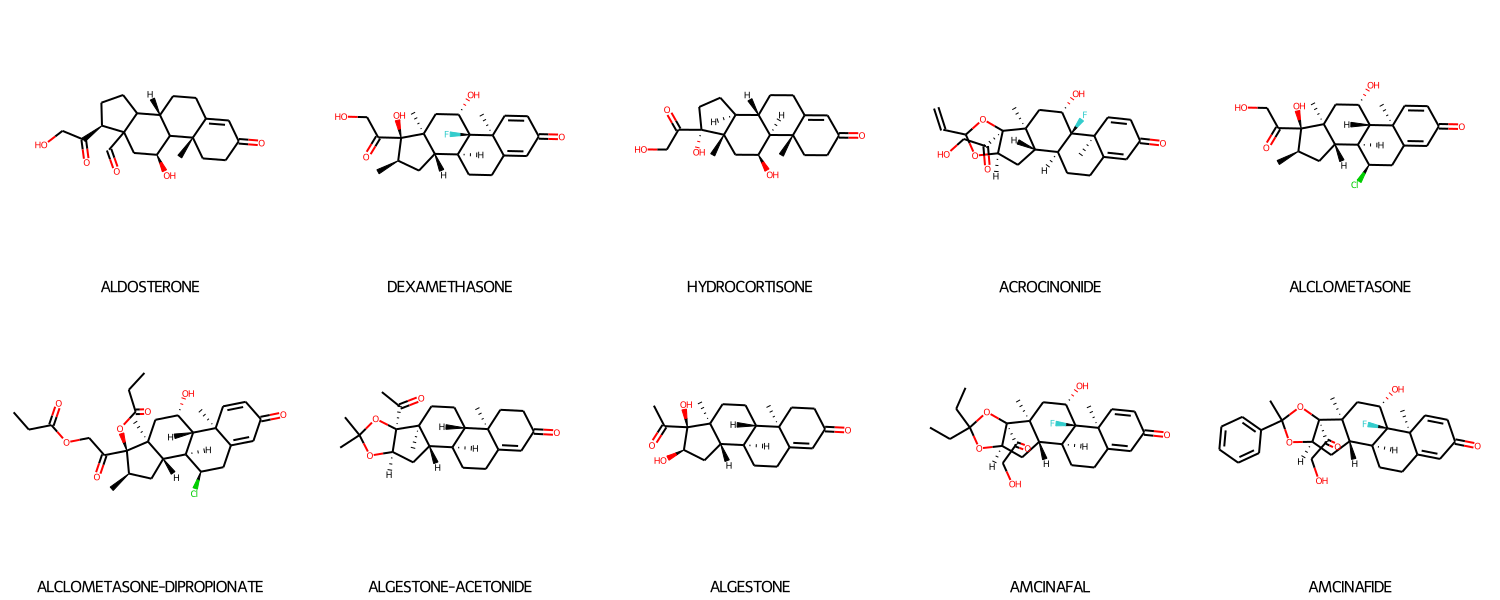

In [42]:
grid_c3

### Cluster 4

In [45]:
fragments_c4, grid_c4 = cluster_fragments(bbb_df[bbb_df['Cluster_Index'] == 4], important_features)

In [47]:
fragments_c4.head(20)

,Fragment,Count
22,c([nH])(c)c,14
6,c(c)(c)C,12
42,N(C)(C)C,11
77,C(c(c)c)[C@H](C)N,10
83,C(C)(C)(c)C,10
68,C([C@H](C)N)c(c)c,9
75,C(c)(C)(C)C,8
19,[C@H](O)(C)C,8
16,C(N)C,8
18,c(C)(c)c,8


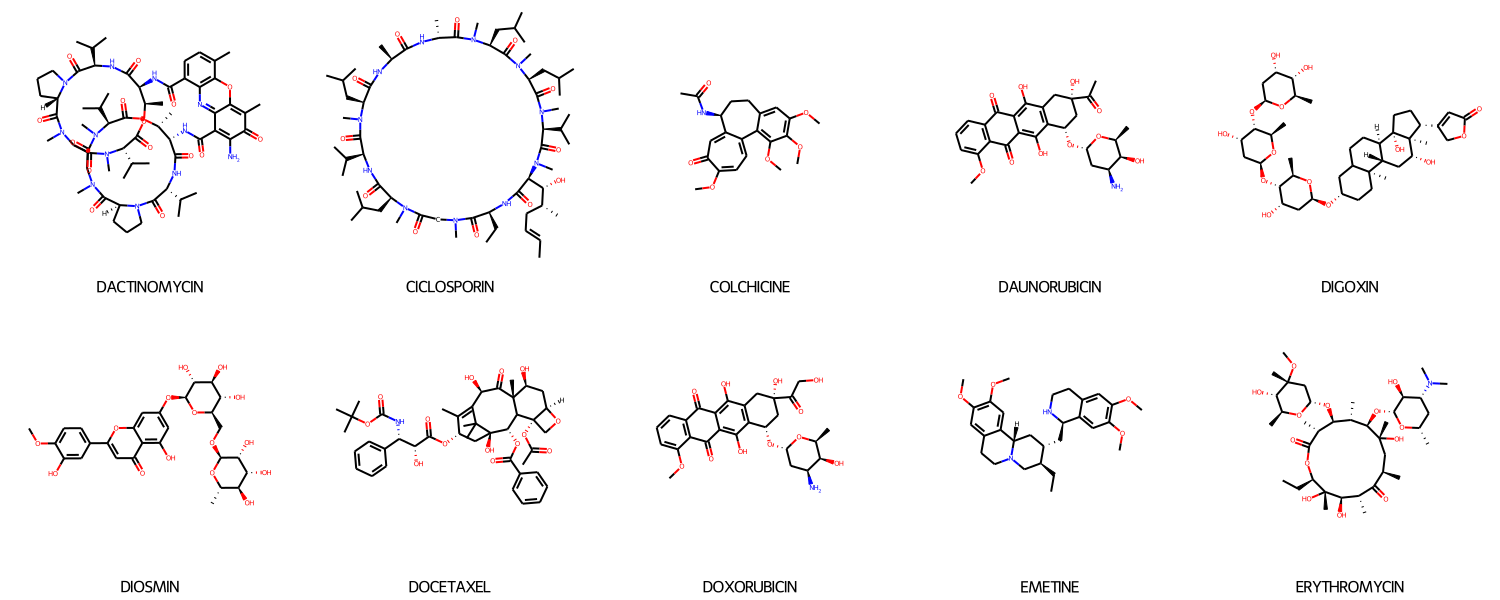

In [48]:
grid_c4

In [43]:
bbb_df[bbb_df['Drug'] == 'AMOXICILLIN']['SMILES'].values

array(['CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(cc3)O)C(=O)N2[C@H]1C(O)=O'],
      dtype=object)